In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata, kruskal
from scikit_posthocs import posthoc_dunn
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [42]:
# Function to preprocess the dataset (remove alternate columns, convert types, etc.)
def preprocess_dataset(file_path):
    """
    Preprocess the dataset by removing alternate columns, converting types, and setting factor levels.

    Parameters:
    - file_path (str): Path to the CSV file containing the dataset.

    Returns:
    - dataset (DataFrame): Preprocessed dataset with selected columns, appropriate types, and categorical encoding.
    """
    # Load dataset
    dataset = pd.read_csv(file_path)

    # Remove every other column from column 4 to 1122
    cols_to_remove = [col for i, col in enumerate(dataset.columns[3:], start=4) if i % 2 == 0]
    dataset.drop(columns=cols_to_remove, inplace=True)

    # Remove the first row
    dataset = dataset.iloc[1:, :]

    # Remove Sampes Column
    dataset = dataset.drop(columns=['Samples'])

    # Convert Pos_Neg to categorical and set specific levels
    pos_neg_order = ["Healthy", "Flu", "RSV", "Covid", "Cancer"]
    dataset['Pos_Neg'] = pd.Categorical(dataset['Pos_Neg'], categories=pos_neg_order, ordered=False)

    # Filter the dataset to include only 'Healthy' and 'Covid' samples
    dataset = dataset[dataset['Pos_Neg'].isin(['Cancer', 'Covid'])]

    # Remove unused categories in the 'Pos_Neg' column
    dataset['Pos_Neg'] = dataset['Pos_Neg'].cat.remove_unused_categories()

    # Convert all columns (except first two) to numeric
    dataset.iloc[:, 2:] = dataset.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

    return dataset


In [43]:
# Function to balance the dataset using oversampling
def balance_dataset(dataset):
    """
    Balance the dataset using random oversampling.

    Parameters:
    - dataset (DataFrame): Input dataset with features and a target column named 'Pos_Neg'.

    Returns:
    - balanced_dataset (DataFrame): Dataset with balanced classes by oversampling the minority classes.
    """
    # Split features and target
    X = dataset.drop(columns=['Pos_Neg'])
    y = dataset['Pos_Neg']

    # Perform random oversampling
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X, y)

    # Combine the resampled dataset
    balanced_dataset = pd.concat([pd.Series(y_res, name='Pos_Neg'), pd.DataFrame(X_res, columns=X.columns)], axis=1)
    return balanced_dataset


In [44]:
# Function to train a random forest model and extract important features
def train_random_forest(dataset, target_col):
    """
    Train a random forest model and extract important features.

    Parameters:
    - dataset (DataFrame): Input dataset with features and target column.
    - target_col (str): Name of the target column in the dataset.

    Returns:
    - rf_model (RandomForestClassifier): Trained random forest model.
    - feature_importances (DataFrame): DataFrame with features and their importance scores.
    """
    # Split the dataset into features and target
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    # Encode target labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Train a random forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y_encoded)

    # Extract feature importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    return rf_model, feature_importances

In [79]:
# Function to plot a feature by category
def plot_feature_by_category(dataset, feature_col, target_col):
    """
    Plot a feature distribution by category using boxplot and stripplot.

    Parameters:
    - dataset (DataFrame): Input dataset containing the features and target.
    - feature_col (str): Name of the feature column to plot.
    - target_col (str): Name of the target column to group the feature values.

    Returns:
    - None
    """
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=target_col, y=feature_col, data=dataset, palette='pastel6')
    sns.stripplot(x=target_col, y=feature_col, data=dataset, color='black', alpha=0.5)
    plt.title(f'{feature_col} by {target_col}')
    plt.show()

In [80]:
# Function to perform Dunn's test
def perform_dunn_test(dataset, feature_col, target_col):
    """
    Perform Dunn's test to compare multiple groups using the specified feature.

    Parameters:
    - dataset (DataFrame): Input dataset containing the feature and target columns.
    - feature_col (str): Name of the feature column to analyze.
    - target_col (str): Name of the target column that defines the groups.

    Returns:
    - dunn_result (DataFrame): Result of the Dunn's test, showing p-values for pairwise comparisons.
    """
    dunn_result = posthoc_dunn(dataset, val_col=feature_col, group_col=target_col, p_adjust='bonferroni')
    return dunn_result


In [81]:
# Function to perform Recursive Feature Elimination (RFE)
def perform_rfe(dataset, target_col):
    """
    Perform Recursive Feature Elimination (RFE) to identify important features.

    Parameters:
    - dataset (DataFrame): Input dataset with features and target.
    - target_col (str): Name of the target column.

    Returns:
    - rfe (RFE): Trained RFE model with support and ranking of features.
    """
    # Split the dataset into features and target
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    # Encode target labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Train a random forest model and perform RFE
    rf_model = RandomForestClassifier(random_state=42)
    rfe = RFE(rf_model, n_features_to_select=10)
    rfe.fit(X, y_encoded)
    return rfe


In [82]:
def perform_pca(dataset, exclude_cols):
    """
    Perform Principal Component Analysis (PCA) on the dataset, excluding specified columns.

    Parameters:
    - dataset (DataFrame): Input dataset with features.
    - exclude_cols (list): List of columns to exclude before performing PCA.

    Returns:
    - pca (PCA): Fitted PCA model.
    - pca_result (ndarray): Transformed dataset using the first principal component.
    """
    # Remove specified columns and perform PCA
    pca_dataset = dataset.drop(columns=exclude_cols)
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(pca_dataset)
    return pca, pca_result

In [83]:
# 1. Preprocess the dataset
dataset = preprocess_dataset("/Users/vignesh/Documents/Data science/Machine Learning/NEW EDA TRIAL 1/Breathonix All data.csv")

In [84]:
# 2. Balance the dataset
balanced_dataset = balance_dataset(dataset)


In [85]:
# 3. Train a random forest model
rf_model, rf_importance = train_random_forest(balanced_dataset, "Pos_Neg")

# Display the random forest model output and feature importance
print("Random Forest Model:\n", rf_model)
print("Feature Importance:\n", rf_importance)

Random Forest Model:
 RandomForestClassifier(random_state=42)
Feature Importance:
       Feature  Importance
179  m143.900    0.050000
229      m193    0.050000
26      r_N2H    0.050000
6    m016.450    0.040998
52      r_NO2    0.040000
..        ...         ...
207      m171    0.000000
206      m170    0.000000
205      m169    0.000000
204      m168    0.000000
559      m500    0.000000

[560 rows x 2 columns]


<ipython-input-79-381ec34ad73a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature_col, data=dataset, palette='pastel6')


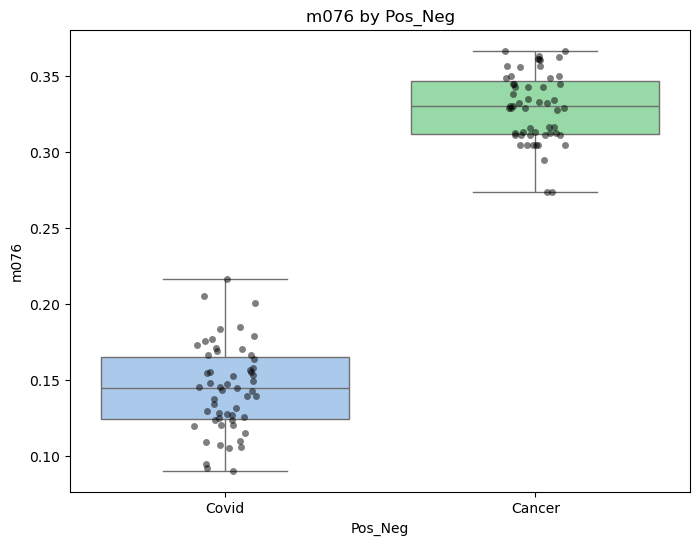

In [86]:
plot_feature_by_category(balanced_dataset, "m076", "Pos_Neg")